In [ ]:
# Peter John Enriquez 2019-03086
# ECE 197 Z-MWZ Deep Learning

# Project 1: Zero-Shot Object Detection Using Segment Anything Model(SAM)
SAM is a new model that can basically segment anything in an image. It accepts prompts: points, bounding boxes, masks and/or text. The output is mask segmentation. 

In this project, the aim is to use SAM to perform zero-shot object detection using COCO 2017 val split. 

## Environment Set-up
To assure proper implementation of the succeeding codes, the following directory arrangement is suggested:
* images
  * aki_dog.jpg <br>
    ...
* coco2017
  * annotations
    * instances_val2017.json <br>
    ...
  * val2017
    * 000000000139.jpg <br>
    ...
* mcheckpoints
  * sam_vit_b_01ec64.pth
  * sam_vit_h_4b8939.pth
  * sam_vit_l_0b3195.pth
* outputs_sample
* test_log  
* project1_sam_demo.ipynb
* project1_sam_val.py

In [1]:
import sys
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

# add. for COCO 2017 dataset
import cv2
import os
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from einops import rearrange

# for SAM Mask Generator
import numpy as np
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# for OpenClip
import open_clip
import urllib
from PIL import Image

# add. for plotting
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

# add. for COCO mAP calculation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# add. for input/image input
import urllib.request
import validators
import argparse
import random

# add. for YOLOV8
from pytriton.client import ModelClient

# add. for info/tracking
import time
import json

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


PyTorch version: 1.13.1+cu116
Torchvision version: 0.14.1+cu116
CUDA is available: True


## COCO 2017 Dataset
Before the demonstration, we first have to set-up our dataset. 

While we're at it, we can define the dictionaries we need to map the category_id to the category/label used in the COCO 2017 dataset and vice versa. These dictionaries are named `idx2label` and `label2idx`. Since the `category_id` spans from 1-91 yet there are only 80 categories used in the COCO 2017 dataset, we also defined the list `cocolabels` containing all the possible labels which will be useful when using OpenCLIP. Additional categories such as `background:0` and `unknown:91` were also added for object detection filtration later on. 

`idx2label`, `label2idx` and `cocolabels` are all defined to be global variables

In [2]:
# define the path to the dataset
THIS_FOLDER = os.path.join(os.path.dirname(os.path.abspath('__file__')))
coco_dataset_dir = os.path.join(THIS_FOLDER, "coco2017","val2017")
coco_annotation_file = os.path.join(THIS_FOLDER,"coco2017","annotations", "instances_val2017.json")
print("image directory: ", coco_dataset_dir)
print("annotation file: ", coco_annotation_file)

# define the transforms to apply to the images
def convert_to_uint8(x):
    return x.mul(255).byte()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(convert_to_uint8), # Convert to uint8 format 
    ])

# load the dataset
coco_val_dataset = datasets.CocoDetection(root=coco_dataset_dir, annFile=coco_annotation_file, transform=transform)

# create the labels dictionaries
with open(coco_annotation_file) as f:
        coco_annotations = eval(f.read())
categories = coco_annotations['categories']
idx2label = {}
label2idx = {}
for category in categories:
    idx2label[category['id']] = category['name']
    label2idx[category['name']] = category['id']
idx2label[0] = 'background'
idx2label[91] = 'unkown'
#idx2label[92] = 'others'
label2idx['background'] = 0
label2idx['unknown'] = 91
#label2idx['others'] = 92
idx2label = dict(sorted(idx2label.items()))
coco_labels = list(idx2label.values())

#print('idx2label items: ', idx2label.items())
#print("coco labels size: ", len(idx2label))



image directory:  c:\Users\pjohn\OneDrive\Documents\EEE197DL\Deep-Learning-Experiments\versions\2022\project1\coco2017\val2017
annotation file:  c:\Users\pjohn\OneDrive\Documents\EEE197DL\Deep-Learning-Experiments\versions\2022\project1\coco2017\annotations\instances_val2017.json
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!


## SAM Mask Generator
The following function initializes our sam model depending on which model is called: `SAM_h`, `SAM_l` or `SAM_b`

In [3]:
def initiate_sam_model(model):
    if model == "SAM_b":
        sam_checkpoint = os.path.join(THIS_FOLDER, "mcheckpoints", "sam_vit_b_01ec64.pth")
        model_type = "vit_b"
    elif model == "SAM_l":
        sam_checkpoint = os.path.join(THIS_FOLDER, "mcheckpoints", "sam_vit_l_0b3195.pth")
        model_type = "vit_l"
    elif model == "SAM_h":
        sam_checkpoint = os.path.join(THIS_FOLDER, "mcheckpoints", "sam_vit_h_4b8939.pth")
        model_type = "vit_h"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    return sam

SAM mask generator returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Using the following `cropper` function, we generate a list of smaller images which are the crops of the image used to generate the masks. It uses the `bbox` key to locate the region of interest which we will task OpenCLIP to put a label on.

In [4]:
# CROPPING THE IMAGE BASED ON THE BOUNDING BOXES
# Note: image is a numpy array, HWC, uint8
def cropper(image, anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    image_boxes = []
    for ann in sorted_anns:
        bbox = ann['bbox']
        bbox = [int(i) for i in bbox]
        x, y, w, h = bbox
        roi = image[y:y+h, x:x+w,:]
        height, width, channels = roi.shape
        if width == 0 or height == 0: # to avoid errors
            continue
        else:
            image_boxes.append({'bbox':bbox, 'image': roi, 'area': ann['area']})

    return image_boxes

## OPENCLIP
The following function initializes our OpenCLIP model, `ViT-B-32`. Here we use `coco_labels` as our tokenizer which will limit the text mapping OpenCLIP does within the COCO 2017 80 categories (plus the added categories).

In [5]:
# PREPARING OPENCLIP MODEL
def initiate_openclip():
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer(coco_labels)

    return model, preprocess, text

The following `clip_labeler` function takes in an image and the outputs from our openclip initialization to predict a label for the image. It outputs its prediction as a dictionary containing the `category`, `category_id`, and `score` (text probability of the chosen label)

On the other hand, the `detector` function iterates over the image crops we get from the `cropper` function and put a label on them using the `clip_labeler` function. It outputs a list of dictionaries containing the `image_id`, `category_id`, `bbox`, `score`, and `area` associated with the image.

In [6]:
# GIVE LABEL TO A BOUNDING BOXES
# Note: label2idx is set as a global variable
def clip_labeler(image, text, preprocess, model):
    model.to(device)
    labels = list(idx2label.values())
    image = Image.fromarray(image)
    image = preprocess(image).unsqueeze(0)
    image = image.to(device)
    text = text.to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

    index = np.argmax(text_probs.cpu().numpy())
    label_id = label2idx[labels[index]]
    prediction = {'category': labels[index], 'category_id': label_id, 'score': text_probs.cpu().numpy()[0][index]}
    return prediction

# GIVE LABEL TO EVERY BOUNDING BOXES IN THE IMAGE
# Note: image_id, text, preprocess, and openclip_b32 are set as global variables
def detector(images):
    predictions = []
    for image_crop in images:
        label_prediction = clip_labeler(image = image_crop['image'], text = text, preprocess = preprocess, model = openclip_b32) 
        predictions.append({'image_id':image_id, 'category_id':label_prediction['category_id'], 'bbox': image_crop['bbox'], 'score': label_prediction['score'], 'area': image_crop['area']})
    return predictions

The following `detection_filter` function filters the objects detected by SAM and OpenCLIP by removing detections that fits the following characteristics
* the score is less than a certain `threshold` (uncertain)
* the label is not one of COCO 2017 80 categories (outside of scope)
* the detection has the same label as another detection and it a subset of the latter based on a `tolerance` level (part of a bigger picture)

The `threshold` and the `tolerance` is adjustable outside the function to faciliate testing to maximizing mAP.

In [7]:
def detection_filter(predictions, tolerance=5, threshold=0.5):
    i = 0
    while i < len(predictions):
        bbox_i = predictions[i]['bbox']
        cat_i = predictions[i]['category_id']
        score_i = predictions[i]['score']
    
        # Iterate through the remaining predictions with the same category ID
        j = i + 1
        while j <= len(predictions):
            #print("now comparing i= ", i,  " and j= ", j, "  length of list= ", len(predictions))
            if j == len(predictions): # evaluate last element
                #print("now evaluating i= ", i, "  length of list= ", len(predictions))
                if cat_i >= 91 or cat_i == 0 or score_i < threshold:
                    predictions.pop(i)
                    break
                else:
                    break
            
            bbox_j = predictions[j]['bbox']
            cat_j = predictions[j]['category_id']
            score_j = predictions[j]['score']

            # FILTER RULES:
            # Check if bbox_i is a subset of bbox_j, if so, delete entry i
            # Check if cat_i is outside of coco 2017 dataset 80 categories, if so, delete entry i
            # Check if score_i is less than threshold, if so, delete entry i
            if (cat_i == cat_j and bbox_i[0]+tolerance >= bbox_j[0]-tolerance and \
                bbox_i[1]+tolerance >= bbox_j[1]-tolerance and \
                bbox_i[0]+bbox_i[2]-tolerance <= bbox_j[0]+bbox_j[2]+tolerance and \
                bbox_i[1]+bbox_i[3]-tolerance <= bbox_j[1]+bbox_j[3]+tolerance and score_i<score_j) or \
                cat_i >= 91 or cat_i == 0 or score_i < threshold:
                predictions.pop(i)
                i -= 1 # Update the index to account for the removed element
                break # Move on to the next prediction

            # Check if bbox_j is a subset of bbox_i, if so, delete entry j
            # Check if cat_j is outside of coco 81 categories, if so, delete entry j
            # Check if score_j is less than threshold, if so, delete entry j
            elif (cat_i == cat_j and bbox_i[0]-tolerance <= bbox_j[0]+tolerance and \
                bbox_i[1]-tolerance <= bbox_j[1]+tolerance and \
                bbox_i[0]+bbox_i[2]-tolerance >= bbox_j[0]+bbox_j[2]+tolerance and \
                bbox_i[1]+bbox_i[3]+tolerance >= bbox_j[1]+bbox_j[3]-tolerance and score_j<score_i) or \
                cat_j >= 91 or cat_j == 0 or score_j < threshold:
                predictions.pop(j)
                j -= 1 # Update the index to account for the removed element
            j += 1
        i += 1

    # The updated list contains predictions with no bounding box subset
    return predictions


## Mean Average Precision Calculation
The following function calculates the mAP of the detection system by comparing it to the target using `COCOeval`. The `imgIds` parameter uses the image ids present in the detection system output instead of the COCO target to limit average precision and recall calculation among objects detected within the image set of interest. This also allows us to evaluate the AP for a single image. 

In [8]:
def mAP_calculate(predictions_filtered):
    if len(predictions_filtered)==0:
        return 0
    coco_gt = COCO(coco_annotation_file)
    coco_dt = coco_gt.loadRes(predictions_filtered)
    
    imgIds = sorted(list(set([prediction['image_id'] for prediction in predictions_filtered])))

    cocoEval = COCOeval(coco_gt,coco_dt,'bbox')
    cocoEval.params.imgIds  = imgIds
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()    

    mAP = cocoEval.stats[0] # first AP value: IoU=0.50:0.95
    print('\nmAP:', mAP)
    return mAP

## ADDITIONAL PLOTTING TOOLS
The additional plotting tools below can be used to check the image masks, and the bounding boxes with and without the labels. The `show_boxes_labeled` is designed to work for both our detection system (dict contains `category_id`, no `category`) and the YOLOV8 detection model (contains `category`, no `category_id`) 

In [9]:
# DISPLAY IMAGE WITH MASKS
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

#DISPLAY IMAGES WITH BOUNDING BOXES
def show_boxes_nocat(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        bbox = ann['bbox']
        x, y, w, h = bbox
        color_bbox = np.random.random((1, 3)).tolist()[0]
        rect = Rectangle((x, y), w, h, fill=False, color=color_bbox, linewidth=3)
        ax.add_patch(rect)

#DISPLAY IMAGES WITH BOUNDING BOXES AND CATEGORY
def show_boxes_labeled(anns, coco_labels):
    if len(anns) == 0:
        return
    if 'area' in anns[0]:
        sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    else:
        sorted_anns = anns
    ax = plt.gca()
    ax.set_autoscale_on(False)
    if 'category' not in sorted_anns[0]:
        category_ids = set([ann['category_id'] for ann in sorted_anns])
        num_category = len(category_ids)
        category_to_color = {category_id: matplotlib.colormaps['hsv'](idx / num_category)
                  for idx, category_id in enumerate(category_ids)}
    else:
        category = set([ann['category'] for ann in sorted_anns])
        num_category = len(category)
        category_to_color = {category: matplotlib.colormaps['hsv'](cat / num_category)
                  for cat, category in enumerate(category)}

    for ann in sorted_anns:
        bbox = ann['bbox']
        if 'category' not in ann:
            category_id = ann['category_id']
            label = coco_labels[category_id]
            color = category_to_color[category_id]
        else:
            label = ann['category']
            color = category_to_color[label]

        x, y, w, h = bbox
        rect = Rectangle((x, y), w, h, fill=False, color=color,  linewidth=2)
        ax.add_patch(rect)
        if 'score' in ann:
            score = ann['score']
            ax.text(x, y, f"{label} {score:.3f}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))
        else:
             ax.text(x, y, f"{label}", color='black', fontsize=10, bbox=dict(facecolor=color, alpha=0.5))




## COMPARISON PLOTS
The following functions make it easier to plot the comparison for the ground truth, our system detection and the YOLOV8 detection.
The `plot_coco_comparison` is used to compare the  three of them when the image is a COCO 2017 val split image while the `plot_comparison` is used to compare our system detection and the YOLOV8 detection when it is not one.

In [25]:
# image is set as a global variable
def plot_coco_comparison(target, samxopenclip_predictions, yolo_predictions=None):
    sam_mAP = mAP_calculate(samxopenclip_predictions)
    if yolo_predictions is not None:
        subplots = 3
        figsize = (15,5)
    else:
        subplots = 2
        figsize = (10,5)
    figs, axs = plt.subplots(1, subplots, figsize=figsize )
    axs[0].imshow(image)
    axs[0].set_title('Ground Truth')
    plt.sca(axs[0])
    show_boxes_labeled(target, idx2label)
    plt.axis('off')

    axs[1].imshow(image)
    axs[1].set_title('Object Detected')
    sam_mAP_text = f"mAP: {round(sam_mAP,6)}"
    axs[1].text(0.5, -0.1, sam_mAP_text, transform=axs[0].transAxes, ha='center')
    plt.sca(axs[1])
    show_boxes_labeled(samxopenclip_predictions, idx2label)
    plt.axis('off')
    
    if yolo_predictions is not None:
        axs[2].imshow(image)
        axs[2].set_title('YOLO')
        plt.sca(axs[2])
        show_boxes_labeled(yolo_predictions, idx2label)
        plt.axis('off')
    figs.suptitle('Zero-Shot Object Detection Comparison')
    plt.tight_layout()
    plt.show()
    plt.savefig('object_detection_comparison.png') 

def plot_comparison(samxopenclip_predictions, yolo_predictions):
    subplots = 2
    figsize = (10,5)
    figs, axs = plt.subplots(1, subplots, figsize=figsize)
    axs[0].imshow(image)
    axs[0].set_title('SAMxOpenCLIP Object Detected')
    plt.sca(axs[0])
    show_boxes_labeled(samxopenclip_predictions, idx2label)
    plt.axis('off')
    
    axs[1].imshow(image)
    axs[1].set_title('YOLOV8')
    plt.sca(axs[1])
    show_boxes_labeled(yolo_predictions, idx2label)
    plt.axis('off')
    
    figs.suptitle('Zero-Shot Object Detection Comparison')
    plt.tight_layout()
    plt.show()
    plt.savefig('object_detection_comparison.png') 

## Yolov8 Object Detection
The following `infer_YOLOmodel` function makes inference using the Yolov8 model available on a remote PyTriton server. The server output is repackaged to resemble the list of dictionaries our detection system outputs for easier comparison. Each dictionary on the list contains the `image_id`, `bbox`, `score`, and `category`.   

In [11]:
def infer_YOLOmodel(url="http://202.92.132.48:8000", image="/images/dog_car.jpg", model="Yolov8x"):
    with ModelClient(url, model) as client:
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        YOLO_predictions = []
        for i in range(len(names)): 
            if probs[i] > 0.5: 
                x1, y1, x2, y2 = bboxes[i]
                w = x2 - x1
                h = y2 - y1  
                bbox = [x1, y1, w, h]   
                YOLO_predictions.append({'image_id':image_id,'bbox': bbox, 'score': probs[i], 'category': names[i]})
        return YOLO_predictions           


## SAMxOpenCLIP Object Detection
The following `SAMxOpenCLIP` function makes inference using our SAMxOpenCLIP object detection system and outputs a list of dictionary containing the `image_id`, `category_id`, `bbox`, `score`, and `area` associated with the image. 

The `points_per_batch` parameter of the `SAMAutomaticMaskGenerator` is modifiable outside the function so the demanded GPU memory for running SAM can be easily adjusted. The `threshold` parameter of our `detection_filter` are also modifiable outside the function as mentioned before for further testing.

In [12]:
# Note: sam is set as a global variable
def SAMxOpenCLIP(image, points=64, threshold=0.5):
    mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=points)
    masks = mask_generator.generate(image)
    image_boxes = cropper(image, masks)
    predictions = detector(image_boxes)
    predictions_filtered = detection_filter(predictions, threshold = threshold)

    # Uncomment to check the unfiltered masks or bounding boxes
    #plt.figure(figsize=(10,10))
    #plt.imshow(image)
    #show_anns(masks) #for showing masks
    #show_boxes_nocat(masks) #for showing boxes
    #plt.axis('off')
    #plt.show()

    return predictions_filtered

## Arguments
The following `get_args` function sets the default parameters needed for object detection val/test run but for the object detection demonstration below, it is not needed. It is used to test the perfomance of our object detection system agains the COCO 2017 val test split by allowing command line inputs. 

In [13]:
def get_args():
    parser = argparse.ArgumentParser(description=__doc__)
    choices = ["SAM_h", "SAM_l", "SAM_b"]
    parser.add_argument("--SAMmodel", default=choices[0], choices=choices,
                        help="SAM model (huge, large, base)"),
    parser.add_argument("--image", default="images/dog_car.jpg",
        help="Path to image can filesystem path or url path"),    
    parser.add_argument("--test", default="no",
        help="test for model mAP or not"), 
    parser.add_argument("--url", default="http://localhost:8000",
        help=(
            "Url to Triton server (ex. grpc://localhost:8001)."
            "HTTP protocol with default port is used if parameter is not provided")),
    parser.add_argument("--samppb", default="64",
        help="SAM generate points per batch", required=False),
    parser.add_argument("--threshold", default="0.5",
        help="Detection filter score threshold", required=False), 
    args = parser.parse_args()
    return args

#args = get_args()

# SAMxOpenCLIP Zero-Shot Object Detection Demonstration
Here, we demonstrate our SAMxOpenCLIP object detection system on a single image. The default arguments are already set but it will take an `image_path` input from the user.
### Input Image Path
To test using a:
* **default** image, enter `""` (empty)
* **random coco** image, enter `coco`
* **specific coco** image, enter a valid integer image index (sorted by name); eg. `2`
* valid **image on a url**, enter the url; eg. `https://djl.ai/examples/src/test/resources/dog_bike_car.jpg`
* **image on the same directory**, enter the image path; eg. `images/dog_car.jpg`

The `image_path` input will also determine from which it will be compared to. If it is a COCO image, then the output of the object detection system will be compared with the ground truth and the YOLOV8 output. Else, it is compared with YOLOV8 only. 


SAM model:  SAM_b
image:  coco
test:  no
url:  http://localhost:8000
samppb:  64
threshold:  0.5


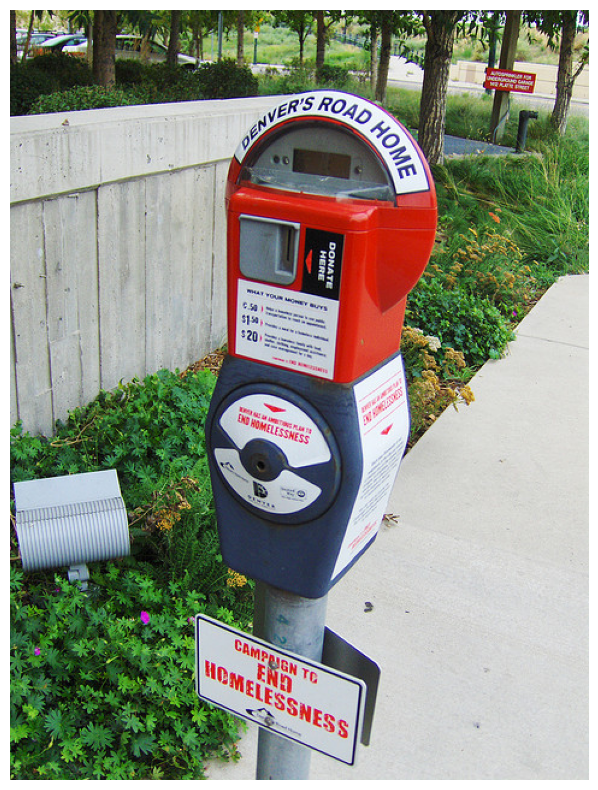

In [15]:
## INPUT IMAGE
def is_integer(image_path):
    try:
        int(image_path)
        return True
    except ValueError:
        return False

class args: # Default arguments can be edited here
    SAMmodel = "SAM_h"
    image = "images/dog_car.jpg"
    test = "no"
    url = "http://localhost:8000"
    samppb = 64
    threshold = 0.6

target = None
image_id = None
image_path = input("Enter image path (write 'coco' if you want a random sample from coco 2017 val dataset): ")
#image_path = args.image
args.image = image_path
#print('image_path:', image_path)

# if empty, use default
if image_path == "":
    image_path = os.path.join(THIS_FOLDER, 'images', 'dog_car.jpg')
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #HWC, uint8, np.ndarray

# if 'coco' use random sample from coco_val_dataset
elif image_path == "coco":
    image_index = random.randint(0, len(coco_val_dataset))
    image, target = coco_val_dataset[image_index]    
    image = rearrange(image, 'c h w -> h w c').numpy() #HWC, uint8, np.ndarray
    #print('target', target)
    image_id = target[0]['image_id']
    if len(target)==0:
        target = None
    else:
        image_id = target[0]['image_id']

# if an integer use integer index of coco_val_dataset
elif is_integer(image_path):
    image, target = coco_val_dataset[int(image_path)]
    image = rearrange(image, 'c h w -> h w c').numpy() #HWC, uint8, np.ndarray
    #print('target', target)
    if len(target)==0:
        target = None
    else:
        image_id = target[0]['image_id']
    
# if url, load image
elif validators.url(image_path):
    with urllib.request.urlopen(image_path) as url_response:
        img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
        image = cv2.imdecode(img_array, -1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #HWC, uint8, np.ndarray

else:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #HWC, uint8, np.ndarray

print('\nSAM model: ', args.SAMmodel)
print('image: ', args.image)
print('test: ', args.test)
print('url: ', args.url)
print('samppb: ', args.samppb)
print('threshold: ', args.threshold)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

### Device Check (Optional)

In [15]:
# Check the number of available CUDA devices
num_devices = torch.cuda.device_count()
print("\nNumber of CUDA devices:", num_devices)

# Get information about each CUDA device
for i in range(num_devices):
    device_got = torch.cuda.get_device_properties(i)
    print(f"Device {i}:")
    print("  Name:", device_got.name)
    print("  Total memory:", device_got.total_memory / 1024**2, "MB")
    print("  CUDA capability:", device_got.major, ".", device_got.minor)
    print("  Multi-processor count:", device_got.multi_processor_count)


Number of CUDA devices: 1
Device 0:
  Name: NVIDIA GeForce GTX 1650
  Total memory: 4095.6875 MB
  CUDA capability: 7 . 5
  Multi-processor count: 16


### Inference on SAMxOpenCLIP and YOLOV8
The following script starts up our SAM and OpenCLIP model and does the inference using both our object detection system and the YOLOV8 model. It then compares it depending on the input.

When using a COCO image, do note that from testing, there are ~50 instances among 5000 in the COCO 2017 val split when the `target` is unsuccessfully retrieved from the `coco_val_dataset`, as such, the `target` is unknown and it is not compared with the ground truth.

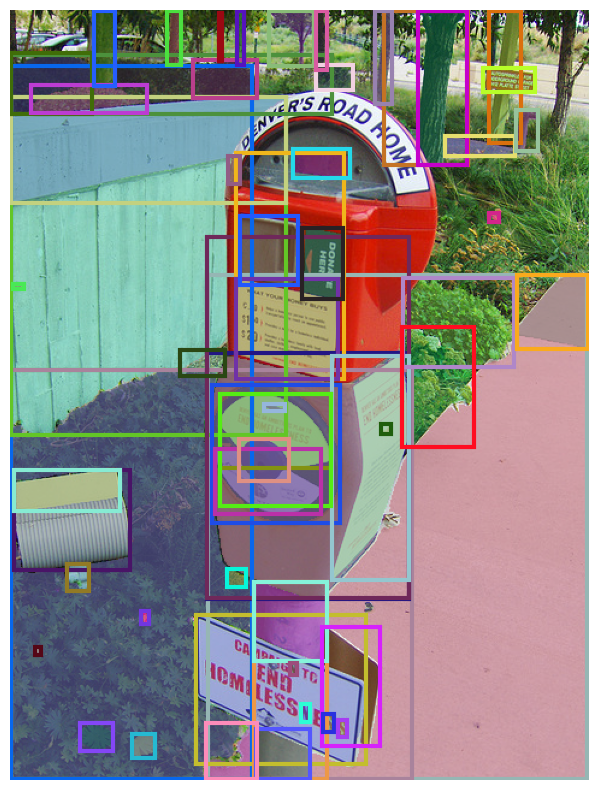

loading annotations into memory...
Done (t=0.82s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

C:\Users\pjohn\AppData\Local\Temp\ipykernel_20872\2559943548.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


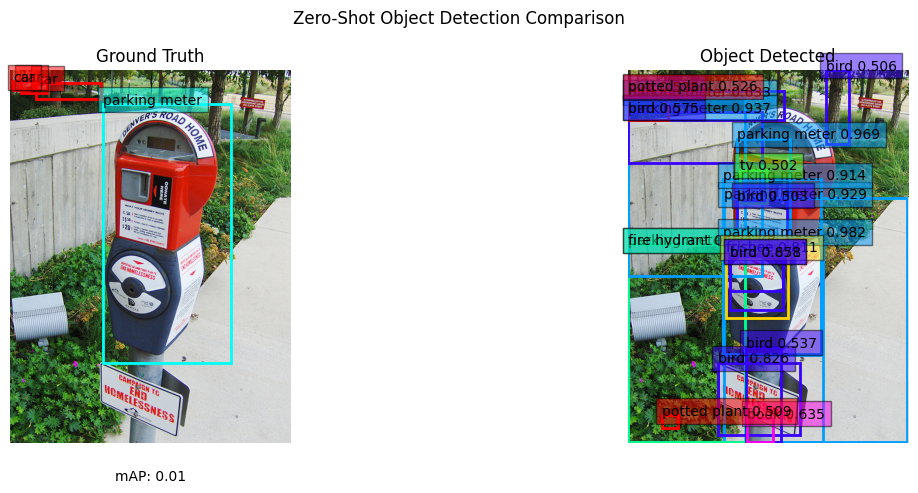

<Figure size 640x480 with 0 Axes>

In [16]:
YOLO_detections = None # for running in system without pytriton client

# SAMxOpenCLIP takes in an image formatted as a HWC, uint8, np.ndarray
sam = initiate_sam_model(args.SAMmodel)
sam.to(device)
openclip_b32, preprocess, text = initiate_openclip()
openclip_b32.to(device)
torch.cuda.empty_cache()

SAM_detections = SAMxOpenCLIP(image=image, points = int(args.samppb),threshold = float(args.threshold))
YOLO_detections = infer_YOLOmodel(image=image, url=args.url)
if target != None:
    plot_coco_comparison(target, SAM_detections, YOLO_detections)
elif YOLO_detections != None:
    plot_comparison(SAM_detections, YOLO_detections)
else:
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_boxes_labeled(SAM_detections, idx2label)
    plt.axis('off')
    plt.show()    

torch.cuda.empty_cache()

## SAMxOpenCLIP Object Detection System Test Run
The following script is used for the validation/test run on the SAMxOpenCLIP object detection system using the COCO 2017 val split. Using the default arguments, it will not run. 

Information about the run such as the `SAM model` used, the `points per batch` used to generate the masks, the filter `threshold`, and the total `execution time` is recorded. The list of the detections is also saved as a json file. This can be used to perform tests without running the validation run again or to compare its performance on a 'per image' or 'image set' basis.

As mentioned before, there are instances when the `coco_val_dataset` fails to retrieve the `target`. To avoid mislabeling `image_ids`, these instances are disregarded instead and are counted using `error_count` while the accounted images and targets are counted using `count`.

Two comprehensive validation/test runs were successfully made, the details are below:
* **First Run:**
  * SAM Model: Sam_h
  * Filter Score Threshold: 0.6
  * Images Accounted: 4952
  * Images Unaccounted (Error): 48
  * mAP @ (IoU=0.50:0.95): 0.05132187976360979
  * Execution Time: 159330.98652291298 seconds (~44hrs)
* **Second Run:**
  * SAM Model: Sam_h
  * Filter Score Threshold: 0.5
  * Images Accounted: 4952
  * Images Unaccounted (Error): 48
  * mAP @ (IoU=0.50:0.95): 0.05106421241657821
  * Execution Time: 173311.92728114128 seconds (~48hrs)


In [18]:
# Test for SAMxOpenCLIP Zero-Shot Object Detection and calculate mAP
start_time = time.time()
#mAP_test = input("type 'yes' to run mAP test: ")
mAP_test = args.test
if mAP_test == "yes":
    detections = []
    count = 0
    error_count = 0
    for image, target in coco_val_dataset:
        image = rearrange(image, 'c h w -> h w c').numpy()
        if len(target)!=0: #bug
            image_id = target[0]['image_id']
        else:
            error_count +=1
            continue
        SAM_detections = SAMxOpenCLIP(image=image, points = int(args.samppb),threshold = float(args.threshold))
        detections.extend(SAM_detections)
        torch.cuda.empty_cache()
        #print("\nafter nth image: \n", torch.cuda.memory_summary(device=None, abbreviated=False))
        count +=1
        #print("number of images accounted: ", count)
    mAP = mAP_calculate(detections)
    #print('\nmAP Calculated: ', mAP)
    print("Images Accounted: ", count)
    print("Images Unaccounted (Error): ", error_count)
    # Convert the float32 values to regular floats
    detections_serializable = []
    for detection in detections:
        detection_serializable = {}
        for key, value in detection.items():
            if isinstance(value, np.float32):
                detection_serializable[key] = value.item()
            else:
                detection_serializable[key] = value
        detections_serializable.append(detection_serializable)

    # Convert the list to a JSON string
    json_data = json.dumps(detections_serializable)

    # Save the JSON string to a file
    with open("SAMdetection.json", "w") as file:
        file.write(json_data)

end_time = time.time()
execution_time = end_time - start_time

print("Run Settings:")
print("  SAM Model: ", args.SAMmodel)
print("  Mask Generator Point Per Batch: ", args.samppb)
print("  Detection Filter Score Threshold: ", args.threshold)
print(f"  Execution time: {execution_time} seconds")  

Run Settings:
  SAM Model:  SAM_b
  Mask Generator Point Per Batch:  64
  Detection Filter Score Threshold:  0.5
  Execution time: 0.0 seconds
